In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import os
import sys
sys.path.append('/home/esther/lc-mapping/scripts')
import landcover_definitions as lc
import util
sys.path.append('/home/esther/torchgeo')
import run_model_forward_and_produce_tifs 
from importlib import reload
reload(run_model_forward_and_produce_tifs)
#import run_through_tiles

<module 'run_model_forward_and_produce_tifs' from '/home/esther/torchgeo/run_model_forward_and_produce_tifs.py'>

In [10]:

def reindex_cc(array_in):
    impervious_idxs_highres_orig = [4,5,6]
    impervious_idx_condensed = 4
    
    reindexed_array = array_in.copy()
    for c_idx in impervious_idxs_highres_orig:
        reindexed_array[array_in == c_idx] = impervious_idx_condensed
            
    return reindexed_array - 1

In [2]:
# classes_keep = [1,2,3,4,6]

# def reindex_ea(array_in, classes_keep):
#     ignore_index = len(classes_keep)
#     reindex_map = dict(zip(classes_keep, np.arange(len(classes_keep))))
#     # reindex shrub to tree
#     tree_idx = 3 # tree idx is 3 when there are no zeros
#     shrub_idx = 5
#     reindexed_mask = -1 * np.ones(array_in.shape)
#     for old_idx, new_idx in reindex_map.items():
#         reindexed_mask[array_in == old_idx] = new_idx

#     reindexed_mask[reindexed_mask == -1] = ignore_index

#     return reindexed_mask

# colors = [lc.lc_colors['enviroatlas'][c] for c in classes_keep]

ny
20


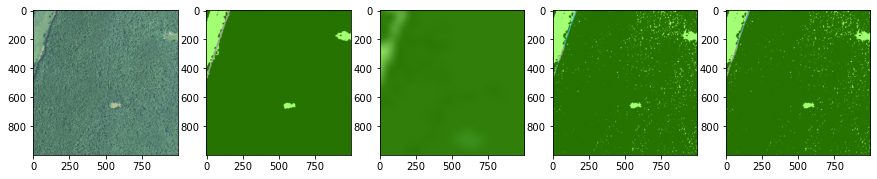

20


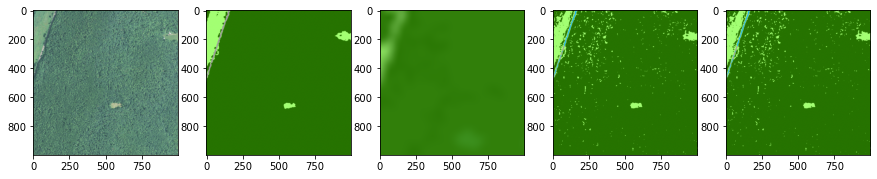

pa
20


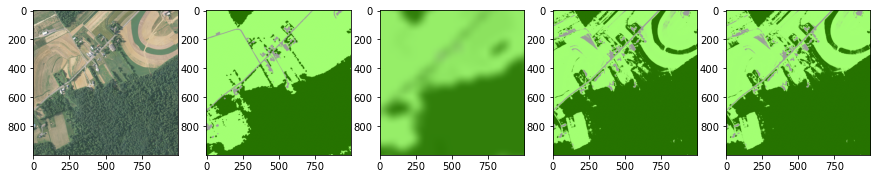

20


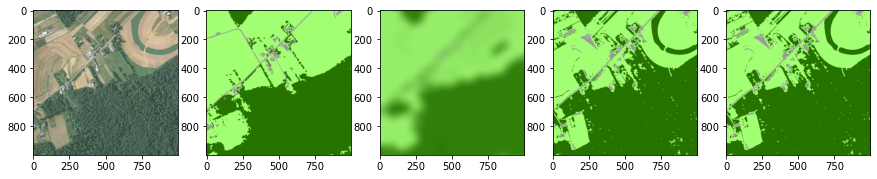

ny+pa
20


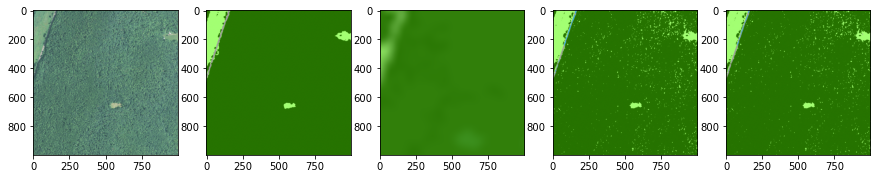

20


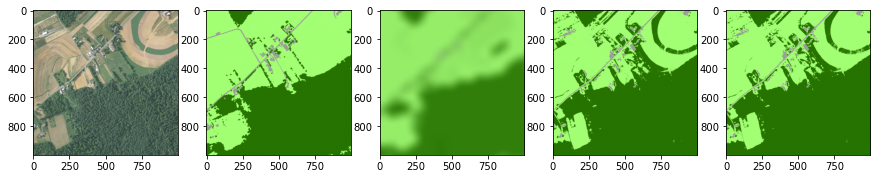

20


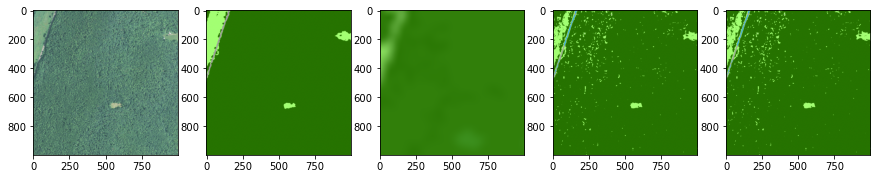

20


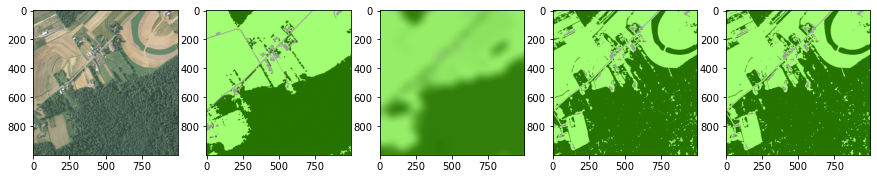

In [14]:
reload(util)

set_this = 'test'
compute_r = True
#results_by_state_q = {}
#results_by_state_r = {}

states_to_eval = ['ny', 'pa', 'ny+pa']

loss_to_eval_options = ['qr_forward', 'qr_reverse']

prior_version = 'from_cooccurrences_101_31_no_osm_no_buildings'
prior_name = f'prior_{prior_version}'
p_add_smooth = 1e-4
lc_type = 'chesapeake_4_no_zeros'

for state_str in states_to_eval:
    print(state_str)
 #   results_by_state_q[state_s] = {}
 #   results_by_state_r[state] = {}
    
    for loss in loss_to_eval_options:
  #  for loss in [1]:
        data_dir = '/home/esther/torchgeo_data/cvpr_chesapeake_landcover'
        
        
        run_name = f'{state_str}_fcn_0.0001_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001/'
        
        pred_dir = f'/home/esther/torchgeo_predictions/{run_name}/cvpr_chesapeake_landcover'
        
        for state in state_str.split('+'):
            state_identifier = f'{state}_1m_2013_extended-debuffered-test_tiles'
            data_dir_this_set = os.path.join(data_dir,state_identifier)
            pred_dir_this_set = os.path.join(pred_dir,state_identifier)
        
            fns = os.listdir(data_dir_this_set)
            tile_ids = np.unique([x[:17] for x in fns])
            print(len(tile_ids))

            for tile_id in tile_ids[:1]:
            #or tile_id in tile_ids[:1]:
                fn_this = os.path.join(data_dir_this_set, f'{tile_id}_lc.tif')
                pred_fn_this = os.path.join(pred_dir_this_set, f'{tile_id}_{loss}_pred_last.tif')
                t1 = time.time()


                # gather the data
                with rasterio.open(fn_this.replace('lc', 'naip-new')) as f:
                    img_this = f.read()
                with rasterio.open(fn_this) as f:
                    hr_lc = f.read()[0]
                # don't need to reindex hr_lc for chesapekae
                hr_lc = reindex_cc(hr_lc)
                preds_this_soft = rasterio.open(pred_fn_this).read()

                # now do r
                if compute_r:
                    prior_this = rasterio.open(fn_this.replace('lc.tif',f'{prior_name}.tif')).read()
                    # first normalize
                    prior = prior_this / prior_this.sum(axis=0)
                    # now add smoothing and renormalize 
                    prior = (prior + p_add_smooth) / (prior + p_add_smooth).sum(axis=0)

                    z = (preds_this_soft.T / preds_this_soft.sum(axis=(1,2)) ).T
                    preds_r_soft = (prior*z)/(prior*z).sum(axis=0)

                    h1, h2 = 1000,2000
                    w1,w2 = 1000,2000
                  #  h1, h2 = img_this.shape[1]-200, img_this.shape[1]
                  #  w1,w2 = img_this.shape[2]-200, img_this.shape[2]
                    fig, ax = plt.subplots(1,5,figsize=(15,3))
                    ax[0].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
                    ax[1].imshow(lc.vis_lc(hr_lc[h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    ax[2].imshow(lc.vis_lc(prior[:,h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    ax[3].imshow(lc.vis_lc(preds_this_soft[:,h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    ax[4].imshow(lc.vis_lc(preds_r_soft[:,h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    plt.show()

                else:
                    h1, h2 = 0,1000,2000
                    w1,w2 = 1000,2000
                    fig, ax = plt.subplots(1,3,figsize=(15,3))
                    ax[0].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
                    ax[1].imshow(lc.vis_lc(hr_lc[h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    ax[2].imshow(lc.vis_lc(preds_this_soft[:,h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    plt.show()

In [52]:
tile_id = '3311133_nw'

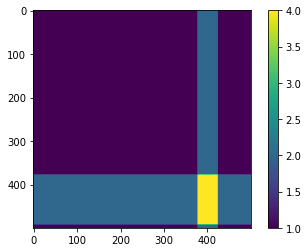

In [63]:
pred_fn_this = os.path.join(pred_dir_this_set, f'{tile_id}_{loss}_pred_last_argmaxed.tif')
counts = rasterio.open(pred_fn_this).read()[0]

plt.imshow(counts[-500:,-500:])
plt.colorbar()

10


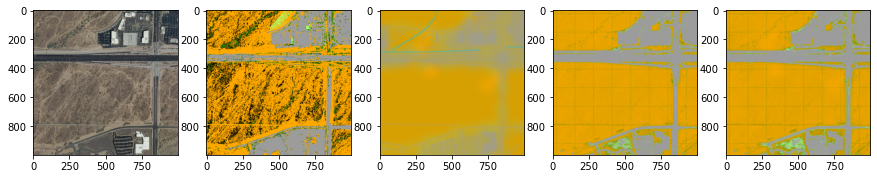

10


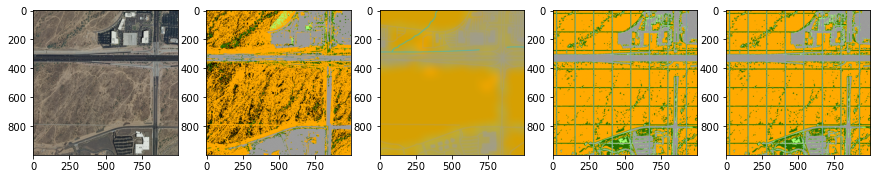

10


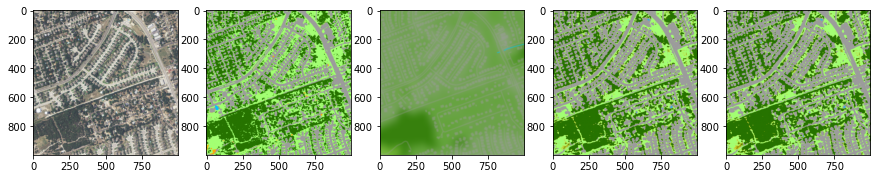

10


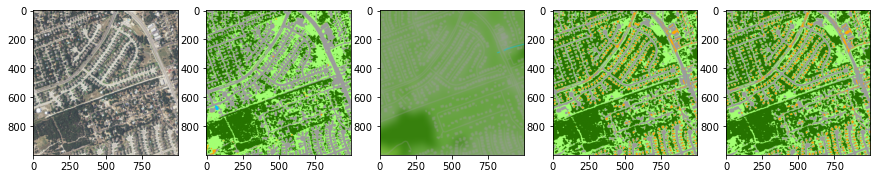

10


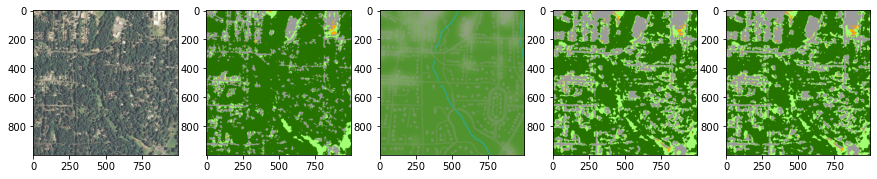

10


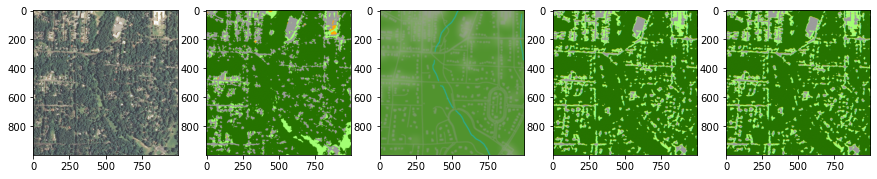

10


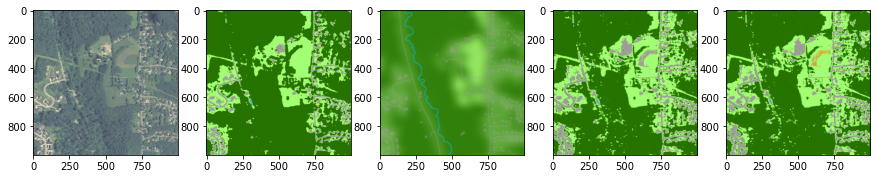

10


/tmp/ipykernel_15643/2900714712.py:77: RuntimeWarning: invalid value encountered in true_divide
  z = (preds_this_soft.T / preds_this_soft.sum(axis=(1,2)) ).T


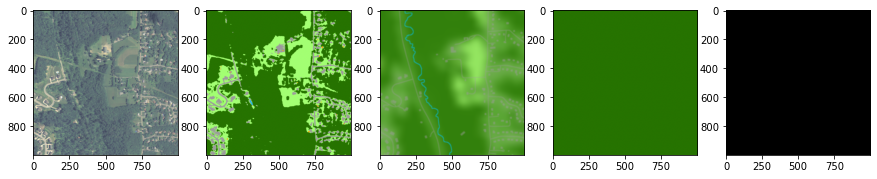

In [36]:
reload(util)

set_this = 'test'
results_by_state_q = {}
results_by_state_r = {}

states_to_eval = ['phoenix_az-2010_1m',
                  'austin_tx-2012_1m',
                  'durham_nc-2012_1m', 
                  'pittsburgh_pa-2010_1m'
                ]

loss_to_eval_options = ['qr_forward', 'qr_reverse']

prior_version = 'from_cooccurrences_101_31'
prior_name = f'prior_{prior_version}'
p_add_smooth = 1e-4

for state in states_to_eval:
    results_by_state_q[state] = {}
    results_by_state_r[state] = {}
    
    for loss in loss_to_eval_options:
  #  for loss in [1]:
        data_dir = '/home/esther/torchgeo_data/enviroatlas'
        data_dir_this_set = os.path.join(data_dir,f'{state}-{set_this}_tiles-debuffered')
        
      # 1. qr from pa checkpoint
        run_name = f'pa_checkpoint_{state}_fcn_1e-05_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001'
        compute_r = True
        
        # 2. qr from scratch
        if loss == 'qr_forward':
            run_name = f'{state}_fcn_0.0001_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001'
        elif loss == 'qr_reverse':
            run_name = f'{state}_fcn_0.001_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001'
        
        
        # 3. highres with prior as input
     #   run_name = f'pittsburgh_pa-2010_1m_fcn_0.001_nll_with_prior'
     #   compute_r = False
        
        # 4. highres withput prior as input
   #     run_name = f'pittsburgh_pa-2010_1m_fcn_0.001_nll'
   #     compute_r = False
        
        
        pred_dir = f'/home/esther/torchgeo_predictions/{run_name}/enviroatlas'
        pred_dir_this_set = os.path.join(pred_dir,f'{state}-{set_this}_tiles-debuffered')

        fns = os.listdir(data_dir_this_set)
        tile_ids = np.unique([x[:10] for x in fns])
        print(len(tile_ids))

        for tile_id in tile_ids[:1]:
            fn_this = os.path.join(data_dir_this_set, f'{tile_id}_h_highres_labels.tif')
            pred_fn_this = os.path.join(pred_dir_this_set, f'{tile_id}_{loss}_pred_last.tif')
            t1 = time.time()

            
            # gather the data
            with rasterio.open(fn_this.replace('h_highres_labels', 'a_naip')) as f:
                img_this = f.read()
            with rasterio.open(fn_this) as f:
                hr_lc = f.read()[0]
            # reindex
            hr_lc = reindex_ea(lc.map_raw_lc_to_idx['enviroatlas'][hr_lc], classes_keep)

            preds_this_soft = rasterio.open(pred_fn_this).read()
                                        
            # now do r
            if compute_r:
                prior_this = rasterio.open(fn_this.replace('h_highres_labels.tif',f'{prior_name}.tif')).read()

                prior = (prior_this / 255. + p_add_smooth) / (prior_this / 255. + p_add_smooth).sum(axis=0)

                z = (preds_this_soft.T / preds_this_soft.sum(axis=(1,2)) ).T
                preds_r_soft = (prior*z)/(prior*z).sum(axis=0)
            
                h1, h2 = 1000,2000
                w1,w2 = 1000,2000
                fig, ax = plt.subplots(1,5,figsize=(15,3))
                ax[0].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
                ax[1].imshow(lc.vis_lc_from_colors(hr_lc[h1:h2,w1:w2], colors).T.swapaxes(0,1))
                ax[2].imshow(lc.vis_lc_from_colors(prior[:,h1:h2,w1:w2], colors).T.swapaxes(0,1))
                ax[3].imshow(lc.vis_lc_from_colors(preds_this_soft[:,h1:h2,w1:w2], colors).T.swapaxes(0,1))
                ax[4].imshow(lc.vis_lc_from_colors(preds_r_soft[:,h1:h2,w1:w2], colors).T.swapaxes(0,1))
                plt.show()
                
            else:
                h1, h2 = 1000,2000
                w1,w2 = 1000,2000
                fig, ax = plt.subplots(1,3,figsize=(15,3))
                ax[0].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
                ax[1].imshow(lc.vis_lc_from_colors(hr_lc[h1:h2,w1:w2], colors).T.swapaxes(0,1))
                ax[2].imshow(lc.vis_lc_from_colors(preds_this_soft[:,h1:h2,w1:w2], colors).T.swapaxes(0,1))
                plt.show()

In [25]:
with rasterio.open(pred_fn_this) as f:
    print(np.dstack((np.rollaxis(f.read(), 0, 3),np.rollaxis(f.read(), 0, 3))).shape)

(6409, 4780, 10)


In [2]:
classes_keep = [1,2,3,4,6]

def reindex_ea(array_in, classes_keep):
    ignore_index = len(classes_keep)
    reindex_map = dict(zip(classes_keep, np.arange(len(classes_keep))))
    # reindex shrub to tree
    tree_idx = 3 # tree idx is 3 when there are no zeros
    shrub_idx = 5
    reindexed_mask = -1 * np.ones(array_in.shape)
    for old_idx, new_idx in reindex_map.items():
        reindexed_mask[array_in == old_idx] = new_idx

    reindexed_mask[reindexed_mask == -1] = ignore_index

    return reindexed_mask



NameError: name 'output_fns' is not defined

In [41]:
img_this = rasterio.open(fn_this.replace('qr_forward_pred_last.tif',f'a_naip.tif')).read()

In [42]:
colors = [lc.lc_colors['enviroatlas'][c] for c in classes_keep]

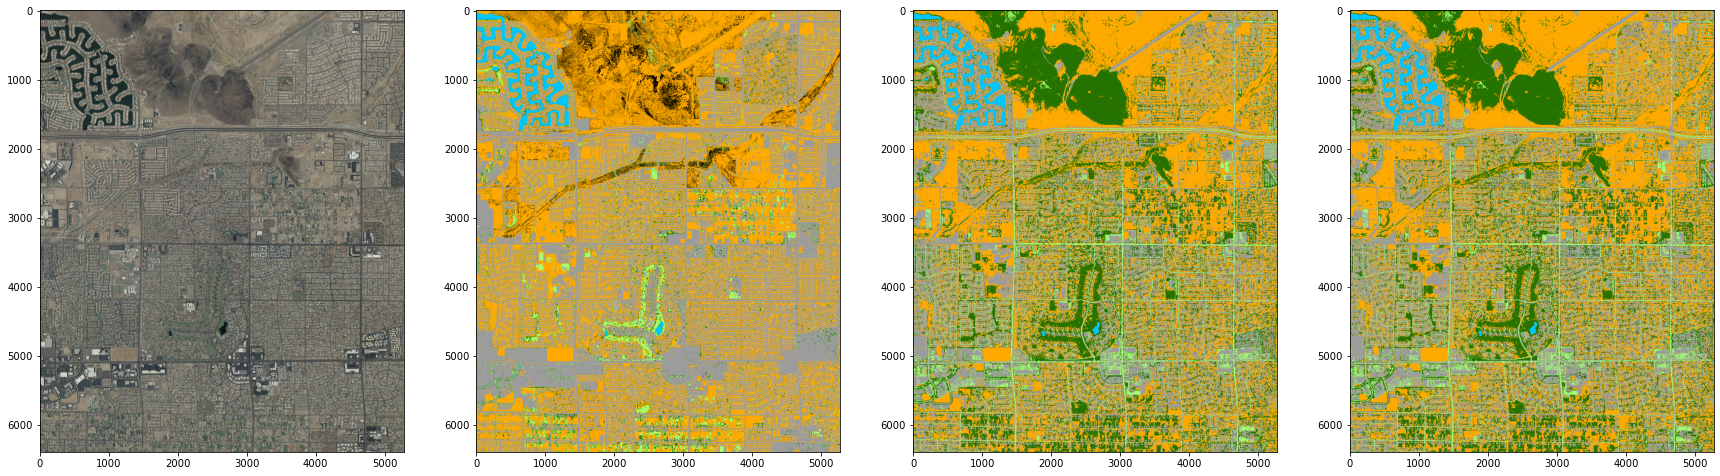

In [44]:
fig, ax = plt.subplots(1,4,figsize=(30,15))
ax[0].imshow(img_this[:3].T.swapaxes(0,1))
ax[1].imshow(lc.vis_lc_from_colors(hr_lc, colors).T.swapaxes(0,1))
ax[2].imshow(lc.vis_lc_from_colors(preds_this.argmax(0), colors).T.swapaxes(0,1))
ax[3].imshow(lc.vis_lc_from_colors(preds_r, colors).T.swapaxes(0,1))

plt.show()

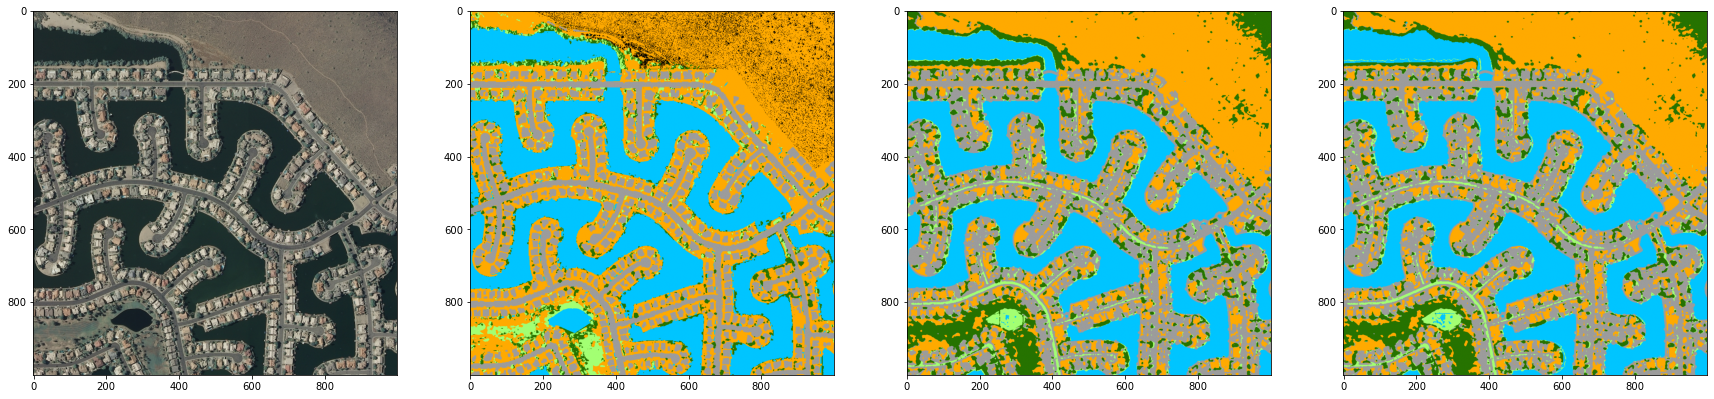

In [46]:
h1, h2 =  0,1000
w1, w2 = 0,1000

fig, ax = plt.subplots(1,4,figsize=(30,15))
ax[0].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
ax[1].imshow(lc.vis_lc_from_colors(hr_lc[h1:h2,w1:w2], colors).T.swapaxes(0,1))
ax[2].imshow(lc.vis_lc_from_colors(preds_this[:,h1:h2,w1:w2].argmax(0), colors).T.swapaxes(0,1))
ax[3].imshow(lc.vis_lc_from_colors(preds_r[h1:h2,w1:w2], colors).T.swapaxes(0,1))

plt.show()

In [2]:
classes_keep = [1,2,3,4,6]
ignore_index = len(classes_keep)

def reindex_ea(array_in, classes_keep):
    ignore_index = len(classes_keep)
    reindex_map = dict(zip(classes_keep, np.arange(len(classes_keep))))
    # reindex shrub to tree
    tree_idx = 3 # tree idx is 3 when there are no zeros
    shrub_idx = 5
    reindexed_mask = -1 * np.ones(array_in.shape)
    for old_idx, new_idx in reindex_map.items():
        reindexed_mask[array_in == old_idx] = new_idx

    reindexed_mask[reindexed_mask == -1] = ignore_index

    return reindexed_mask

In [ ]:
reload(util)

set_this = 'test'
results_by_state_q = {}
results_by_state_r = {}

states_to_eval = ['phoenix_az-2010_1m',
                  'austin_tx-2012_1m',
                  'durham_nc-2012_1m', 
                  'pittsburgh_pa-2010_1m'
                ]

loss_to_eval_options = ['qr_forward', 'qr_reverse']

prior_version = 'from_cooccurrences_101_31'
prior_name = f'prior_{prior_version}'
p_add_smooth = 1e-4

for state in states_to_eval:
    results_by_state_q[state] = {}
    results_by_state_r[state] = {}
    
    for loss in loss_to_eval_options:
    
        data_dir = '/home/esther/torchgeo_data/enviroatlas'
        data_dir_this_set = os.path.join(data_dir,f'{state}-{set_this}_tiles-debuffered')
        
        run_name = f'pa_checkpoint_{state}_fcn_1e-05_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001'
        pred_dir = f'/home/esther/torchgeo_predictions/{run_name}/enviroatlas'
        pred_dir_this_set = os.path.join(pred_dir,f'{state}-{set_this}_tiles-debuffered')

        fns = os.listdir(data_dir_this_set)
        tile_ids = np.unique([x[:10] for x in fns])
        print(len(tile_ids))

        accs_q = []
        ious_q = []
        accs_r = []
        ious_r = []
        num_pix = []
        

        for tile_id in tile_ids:
            fn_this = os.path.join(data_dir_this_set, f'{tile_id}_h_highres_labels.tif')
            pred_fn_this = os.path.join(pred_dir_this_set, f'{tile_id}_{loss}_pred_last.tif')
            t1 = time.time()

            # gather the data
            with rasterio.open(fn_this) as f:
                hr_lc = f.read()[0]
            # reindex
            hr_lc = reindex_ea(lc.map_raw_lc_to_idx['enviroatlas'][hr_lc], classes_keep)

            preds_this_soft = rasterio.open(pred_fn_this).read()
                                        
            preds_this = preds_this_soft.argmax(0)
            acc_this_q = (np.array([hr_lc == preds_this])[np.array([hr_lc!=ignore_index])]).mean()

            # ignore 0
            iou_this_q = util.per_class_iou(hr_lc, preds_this, np.arange(0,len(classes_keep)))
            accs_q.append(acc_this_q)
            ious_q.append(iou_this_q)
            num_pix.append((hr_lc != ignore_index).sum())

            
            # now do r
            prior_this = rasterio.open(fn_this.replace('h_highres_labels.tif',f'{prior_name}.tif')).read()

            prior = (prior_this / 255. + p_add_smooth) / (prior_this / 255. + p_add_smooth).sum(axis=0)

            z = (preds_this_soft.T / preds_this_soft.sum(axis=(1,2)) ).T
            preds_r = (prior*z).argmax(0)
            
            acc_this_r = (np.array([hr_lc == preds_r])[np.array([hr_lc!=ignore_index])]).mean()
            iou_this_r = util.per_class_iou(hr_lc, preds_r, np.arange(0,len(classes_keep)))

            accs_r.append(acc_this_r)
            ious_r.append(iou_this_r)
            
            t2 = time.time()
            print(f'{t2-t1:.2f} seconds')

        ious_aggregated_q = util.aggregate_ious([x[1] for x in ious_q], [x[2] for x in ious_q])
        ious_aggregated_r = util.aggregate_ious([x[1] for x in ious_r], [x[2] for x in ious_r])
        
        acc_aggregated_q = (np.array(accs_q) * np.array(num_pix)).sum() / np.sum(num_pix)
        acc_aggregated_r = (np.array(accs_r) * np.array(num_pix)).sum() / np.sum(num_pix)
        
        print(f'For {state} {set_this} set with {loss} loss:')
        print(f'acc q: {acc_aggregated_q}')
        print(f'mean iou q: {np.mean(ious_aggregated_q[0])}')
        print(f'acc r: {acc_aggregated_r}')
        print(f'mean iou r: {np.mean(ious_aggregated_r[0])}')
        
        print('IoU per class over the tiles (q) is: ')
        print(ious_aggregated_q[0])
        print('IoU per class over the tiles (r) is: ')
        print(ious_aggregated_r[0])
        

        results_by_state_q[state][loss] = {'accs': accs_q,
                                       'ious': ious_q,
                                       'num_pix':num_pix,
                                       'ious_aggregated': ious_aggregated_q,
                                       'acc_aggregated':acc_aggregated_q}
        
        
        results_by_state_r[state][loss] = {'accs': accs_r,
                                       'ious': ious_r,
                                       'num_pix':num_pix,
                                       'ious_aggregated': ious_aggregated_r,
                                       'acc_aggregated':acc_aggregated_r}

10
8.87 seconds
9.00 seconds
8.98 seconds
8.96 seconds
8.87 seconds
8.99 seconds
9.13 seconds
8.81 seconds
8.96 seconds
8.94 seconds
For phoenix_az-2010_1m test set with qr_forward loss:
acc q: 0.7127616748833884
mean iou q: 0.3833081068621897
acc r: 0.7169879768295367
mean iou r: 0.37218385733194537
IoU per class over the tiles (q) is: 
[0.6764762740675725, 0.4656042328664324, 0.6292500207660263, 0.10863889618556277, 0.03657111042535426]
IoU per class over the tiles (r) is: 
[0.5836416268692548, 0.4804351053513761, 0.6309406075037856, 0.10115897122451258, 0.06474297571079782]
10
8.91 seconds
8.95 seconds
8.95 seconds
8.93 seconds
8.81 seconds
8.91 seconds
8.90 seconds
8.79 seconds
9.01 seconds
9.04 seconds
For phoenix_az-2010_1m test set with qr_reverse loss:
acc q: 0.7030621633237482
mean iou q: 0.34937446979023223
acc r: 0.7042109320957355
mean iou r: 0.34838171718524685
IoU per class over the tiles (q) is: 
[0.5725840828419246, 0.37304795787551914, 0.6548839362879482, 0.14309549456

In [94]:
preds_this_soft.shape

(6386, 5261)

In [24]:
accs_by_state = []
ious_by_state = []
num_pix_by_state = []

for state in states:
    accs_by_state.append(results_by_state[state]['accs'])
    ious_by_state.append(results_by_state[state]['ious'])
    num_pix_by_state.append(results_by_state[state]['num_pix'])
    
ious_both_states = np.vstack(ious_by_state)#.ravel()

accs_both_states = np.array(accs_by_state).ravel()
num_pix_both_states = np.array(num_pix_by_state).ravel()

ious_both_states_aggregated = util.aggregate_ious([x[1] for x in ious_both_states], [x[2] for x in ious_both_states])
acc_both_states_aggregated = (accs_both_states * num_pix_both_states).sum() / np.sum(num_pix_both_states)

results_by_state['states_combined'] = {'accs':accs_both_states,
                                       'ious': ious_both_states,
                                       'num_pix': num_pix_both_states,
                                       'ious_aggregated': ious_both_states_aggregated,
                                       'acc_aggregated':acc_both_states_aggregated
                                      }

print(np.mean(results_by_state['states_combined']['ious_aggregated'][0]))
print(np.mean(results_by_state['states_combined']['acc_aggregated']))

0.6723449723188379
0.8802201336957464


In [236]:
np.mean(results_by_state['states_combined']['ious_aggregated'][0])

0.7012840321365993

In [237]:
np.mean(results_by_state['states_combined']['acc_aggregated'])

0.8614745704451643

In [145]:
prior_name = 'prior_from_cooccurrences_0_0_no_osm_no_buildings'

prior_this = rasterio.open(fn_this.replace('lc.tif',f'{prior_name}.tif')).read()
prior = (prior_this / 255. + 1e-4) / (prior_this / 255. + 1e-4).sum(axis=0)

In [146]:
prior_this.shape

(4, 6509, 4830)

In [26]:
preds_this = rasterio.open(output_fns[2]).read()
hr_lc_this  = rasterio.open(output_fns[2].replace('qr_forward_pred','lc')).read()[0]
img_this = rasterio.open(output_fns[2].replace('qr_forward_pred','naip-new')).read()

cc4_lc_reformatted = cc7_to_cc4[hr_lc_this] 


RasterioIOError: /home/esther/torchgeo_data/cvpr_chesapeake_landcover/ny_1m_2013_extended-debuffered-test_tiles/m_4207554_nw_18_1_lc_last.tif: No such file or directory

In [226]:
img_this.shape

(4, 6405, 4742)

In [220]:
(cc4_lc_reformatted == preds_this.argmax(0)).mean()

0.8673200535615924

NameError: name 'img_this' is not defined

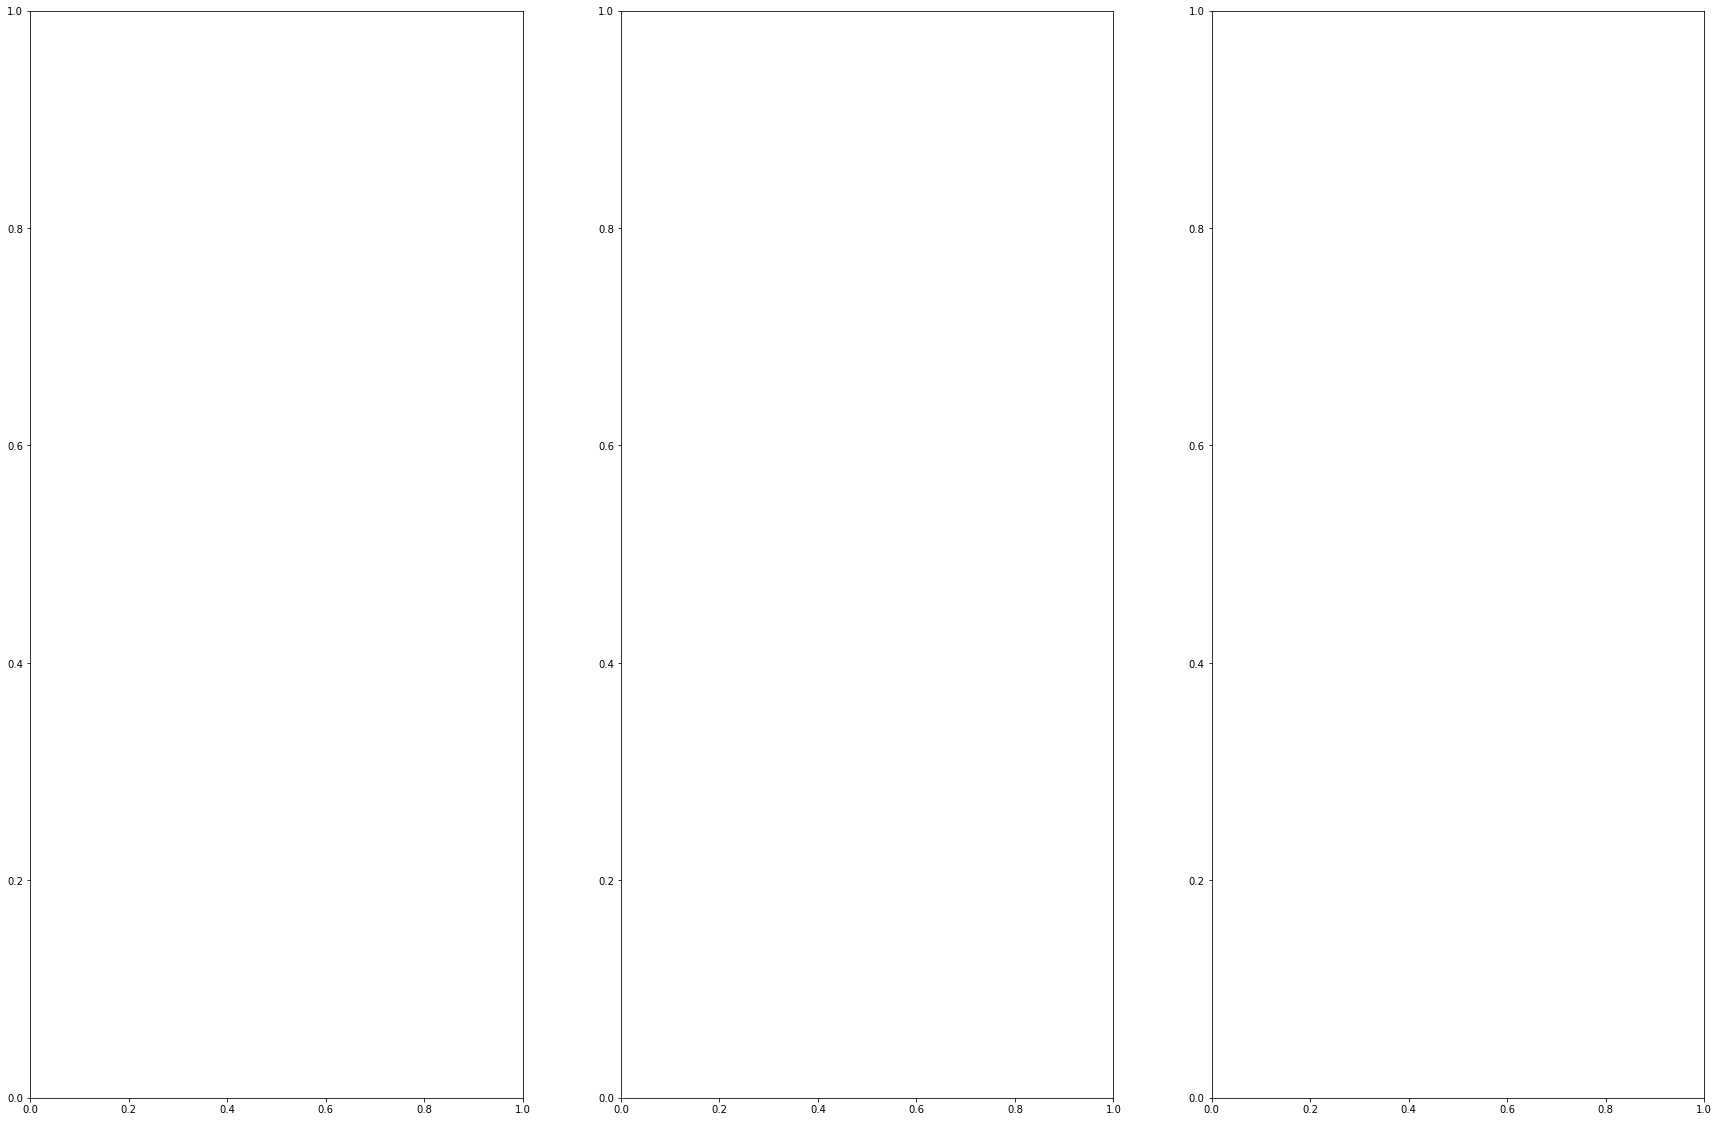

In [25]:
h1, h2 = 1000,3000
w1, w2 = 1000,3000
fig, ax = plt.subplots(1,3,figsize=(30,20))
ax[2].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
ax[0].imshow(lc.vis_lc(cc4_lc_reformatted[h1:h2,w1:w2], 'chesapeake_4_no_zeros').T.swapaxes(0,1))
ax[1].imshow(lc.vis_lc(preds_this[:,h1:h2,w1:w2] / 255., 'chesapeake_4_no_zeros').T.swapaxes(0,1))

In [197]:
preds_this.shape

(6509, 4830)

In [207]:
reload(util)
states = ['pa']#, 'ny']
year = 2013
set_this = 'test'

prior_name = 'prior_from_cooccurrences_0_0_no_osm_no_buildings'

save_2019_map_layer = True

results_r_by_state = {}
for state in states:
    
    data_dir = '/home/esther/torchgeo_data/cvpr_chesapeake_landcover'
    dir_this_set = os.path.join(data_dir,f'{state}_1m_{year}_extended-debuffered-{set_this}_tiles')
    
    fns = os.listdir(dir_this_set)
    tile_ids = np.unique([x[2:17] for x in fns])
    print(len(tile_ids))

    accs = []
    ious = []
    num_pix = []

    for tile_id in tile_ids:
        fn_this = os.path.join(dir_this_set, f'm_{tile_id}_lc.tif')
        t1 = time.time()

        # gather the data
        with rasterio.open(fn_this) as f:
            cc7_lc = f.read()[0]
            
        preds_this = rasterio.open(fn_this.replace('lc.tif','qr_forward_pred_last.tif')).read() / 255.
        prior_this = rasterio.open(fn_this.replace('lc.tif',f'{prior_name}.tif')).read()

        prior = (prior_this / 255. + 1e-4) / (prior_this / 255. + 1e-4).sum(axis=0)
        
        z = (preds_this.T / preds_this.sum(axis=(1,2)) ).T
        preds_r = prior*z
     #   preds_r = (preds_r.T / preds_r.sum(axis=0) ).T.shape
        preds_r = preds_r.argmax(axis=0)
        # realign the classes - lc uses just for classes for this task
        cc4_lc_reformatted = cc7_to_cc4[cc7_lc] 

        acc_this = (preds_r == cc4_lc_reformatted).mean()

        # ignore 0
        iou_this = util.per_class_iou(cc4_lc_reformatted, preds_r, np.arange(0,4))
        accs.append(acc_this)
        ious.append(iou_this)
        num_pix.append(cc4_lc_reformatted.shape[0]*cc4_lc_reformatted.shape[1])

        t2 = time.time()
        print(f'{t2-t1:.2f} seconds')
        
    ious_aggregated = util.aggregate_ious([x[1] for x in ious], [x[2] for x in ious])

    print(f'For {state} {set_this} set:')
    print('IoU (averaged per class) over the tiles is: ')
    print(np.mean(ious_aggregated[0]))
    print('IoU per class over the tiles is: ')
    print(ious_aggregated[0])
    acc_aggregated = (np.array(accs) * np.array(num_pix)).sum() / np.sum(num_pix)
    print('accuracy over the tiles is: ')
    print(acc_aggregated)


    results_r_by_state[state] = {'accs': accs,
                                   'ious': ious,
                                   'num_pix':num_pix,
                                   'ious_aggregated': ious_aggregated,
                                   'acc_aggregated':acc_aggregated}

20
5.22 seconds
5.77 seconds
5.29 seconds
5.22 seconds
5.14 seconds
5.39 seconds
5.32 seconds
5.22 seconds
5.15 seconds
4.85 seconds
4.92 seconds
4.93 seconds
5.01 seconds
5.20 seconds
5.15 seconds
5.14 seconds
5.25 seconds
5.26 seconds
5.25 seconds
5.25 seconds
For pa test set:
IoU (averaged per class) over the tiles is: 
0.6981163200141631
IoU per class over the tiles is: 
[0.6843255369425629, 0.830881035590918, 0.6982093573192907, 0.579049350203881]
accuracy over the tiles is: 
0.8680345890590898
